In [50]:
import pandas as pd
import os
import s3fs
import warnings
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
exec(open('../../0_KPI_functions.py').read())

In [3]:
# Ignore warning
warnings.filterwarnings('ignore')

# Statistiques descriptives : compagnies sport

## Importations et chargement des données

In [4]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [43]:
# création des bases contenant les KPI pour les 5 compagnies de spectacle

# liste des compagnies de spectacle
nb_compagnie=['5','6','7','8','9']

customer_sport = pd.DataFrame()
campaigns_sport_brut = pd.DataFrame()
campaigns_sport_kpi = pd.DataFrame()
products_sport = pd.DataFrame()
tickets_sport = pd.DataFrame()

# début de la boucle permettant de générer des datasets agrégés pour les 5 compagnies de spectacle
for directory_path in nb_compagnie:
    df_customerplus_clean_0 = display_databases(directory_path, file_name = "customerplus_cleaned")
    df_campaigns_brut = display_databases(directory_path, file_name = "campaigns_information", datetime_col = ['opened_at', 'sent_at', 'campaign_sent_at'])
    df_products_purchased_reduced = display_databases(directory_path, file_name = "products_purchased_reduced", datetime_col = ['purchase_date'])
    df_target_information = display_databases(directory_path, file_name = "target_information")
    
    df_campaigns_kpi = campaigns_kpi_function(campaigns_information = df_campaigns_information) 
    df_tickets_kpi = tickets_kpi_function(tickets_information = df_products_purchased_reduced)
    df_customerplus_clean = customerplus_kpi_function(customerplus_clean = df_customerplus_clean_0)

        
# creation de la colonne Number compagnie, qui permettra d'agréger les résultats
    df_tickets_kpi["number_company"]=int(directory_path)
    df_campaigns_brut["number_company"]=int(directory_path)
    df_campaigns_kpi["number_company"]=int(directory_path)
    df_customerplus_clean["number_company"]=int(directory_path)
    df_target_information["number_company"]=int(directory_path)

# Traitement des index
    df_tickets_kpi["customer_id"]= directory_path + '_' +  df_tickets_kpi['customer_id'].astype('str')
    df_campaigns_brut["customer_id"]= directory_path + '_' +  df_campaigns_brut['customer_id'].astype('str')
    df_campaigns_kpi["customer_id"]= directory_path + '_' +  df_campaigns_kpi['customer_id'].astype('str') 
    df_customerplus_clean["customer_id"]= directory_path + '_' +  df_customerplus_clean['customer_id'].astype('str') 
    df_products_purchased_reduced["customer_id"]= directory_path + '_' +  df_products_purchased_reduced['customer_id'].astype('str') 

# Concaténation
    customer_sport = pd.concat([customer_sport, df_customerplus_clean], ignore_index=True)
    campaigns_sport_kpi = pd.concat([campaigns_sport_kpi, df_campaigns_kpi], ignore_index=True)
    campaigns_sport_brut = pd.concat([campaigns_sport_brut, df_campaigns_brut], ignore_index=True) 
    tickets_sport = pd.concat([tickets_sport, df_tickets_kpi], ignore_index=True)
    products_sport = pd.concat([products_sport, df_products_purchased_reduced], ignore_index=True)
    

File path :  projet-bdc2324-team1/0_Input/Company_5/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/products_purchased_reduced.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/products_purchased_reduced.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/products_purchased_reduced.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_8/customerp

In [ ]:
# Construct dataset concerning only customer after start date



## Statistiques descriptives

### 0. Détection du client anonyme (outlier) - utile pour la section 3

In [6]:
sport_comp = tickets_sport['number_company'].unique()
sport_comp

array([5, 6, 7, 8, 9])

In [7]:
def outlier_detection(company_list, show_diagram=False):

    outlier_list = list()
    
    for company in company_list:
        total_amount_share = tickets_sport[tickets_sport['number_company']==company].groupby('customer_id')['total_amount'].sum().reset_index()
        total_amount_share['CA'] = total_amount_share['total_amount'].sum()
        total_amount_share['share_total_amount'] = total_amount_share['total_amount']/total_amount_share['CA']
        
        total_amount_share_index = total_amount_share.set_index('customer_id')
        df_circulaire = total_amount_share_index['total_amount'].sort_values(axis = 0, ascending = False)
        top = df_circulaire[:1]
        outlier_list.append(top.index[0])
        rest = df_circulaire[1:]
    
        # Calculez la somme du reste
        rest_sum = rest.sum()
        
        # Créez une nouvelle série avec les cinq plus grandes parts et 'Autre'
        new_series = pd.concat([top, pd.Series([rest_sum], index=['Autre'])])
        
        # Créez le graphique circulaire
        if show_diagram:
            plt.figure(figsize=(3, 3))
            plt.pie(new_series, labels=new_series.index, autopct='%1.1f%%', startangle=140, pctdistance=0.5)
            plt.axis('equal')  # Assurez-vous que le graphique est un cercle
            plt.title(f'Répartition des montants totaux pour la compagnie {company}')
            plt.show()
    return outlier_list
    

In [8]:
outlier_list = outlier_detection(sport_comp)
outlier_list

['5_191835', '6_591412', '7_49632', '8_1942', '9_19683']

In [9]:
# On filtre les outliers

def remove_elements(lst, elements_to_remove):
    return ''.join([x for x in lst if x not in elements_to_remove])
    
databases = [customer_sport, campaigns_sport, tickets_sport, products_sport]

for dataset in databases:
    dataset['customer_id'] = dataset['customer_id'].apply(lambda x: remove_elements(x, outlier_list))

# On test

bool = '5_191835' in customer_sport['customer_id']
if not bool:
    print("Suppression Réussie")

Suppression Réussie


In [10]:
customer_sport.head()

customer_id  street_id  structure_id  mcp_contact_id  fidelity  tenant_id  \
0   5_6009745    1372685           NaN             NaN         0       1771   
1   5_6011228    1372685           NaN             NaN         0       1771   
2   5_6058950    1372685           NaN             NaN         0       1771   
3   5_6062404    1372685           NaN             NaN         0       1771   
4    5_250217      78785           NaN         11035.0         0       1771   

   is_partner  deleted_at  gender  is_email_true  ...  total_price  \
0       False         NaN       2           True  ...          0.0   
1       False         NaN       2           True  ...          0.0   
2       False         NaN       2           True  ...          0.0   
3       False         NaN       2           True  ...          0.0   
4       False         NaN       0           True  ...          NaN   

  purchase_count  first_buying_date  country  gender_label  gender_female  \
0              0                NaN       af         other              0   
1              0                NaN       af         other              0   
2              0                NaN       af         other              0   
3              0                NaN       af         other              0   
4              0                NaN       fr        female              1   

   gender_male  gender_other  country_fr  number_company  
0            0             1         0.0               5  
1            0             1         0.0               5  
2            0             1         0.0               5  
3            0             1         0.0               5  
4            0             0         1.0               5  

[5 rows x 28 columns]

### 1. customerplus_clean

In [11]:
def compute_nb_clients(customer_sport):
    company_nb_clients = customer_sport[customer_sport["purchase_count"]>0].groupby("number_company")["customer_id"].count().reset_index()
    plt.bar(company_nb_clients["number_company"], company_nb_clients["customer_id"]/1000)

    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Nombre de clients (milliers)")
    plt.title("Nombre de clients de chaque compagnie de sport")
    
    # Affichage du barplot
    plt.show()

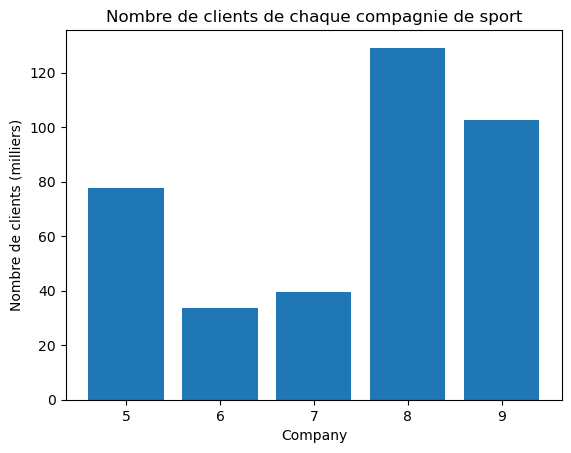

In [12]:
compute_nb_clients(customer_sport)

In [13]:
def maximum_price_paid(customer_sport):
    company_max_price = customer_sport.groupby("number_company")["max_price"].max().reset_index()
    # Création du barplot
    plt.bar(company_max_price["number_company"], company_max_price["max_price"])
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Prix maximal d'un billet vendu")
    plt.title("Prix maximal de vente observé par compagnie de sport")
    
    # Affichage du barplot
    plt.show()

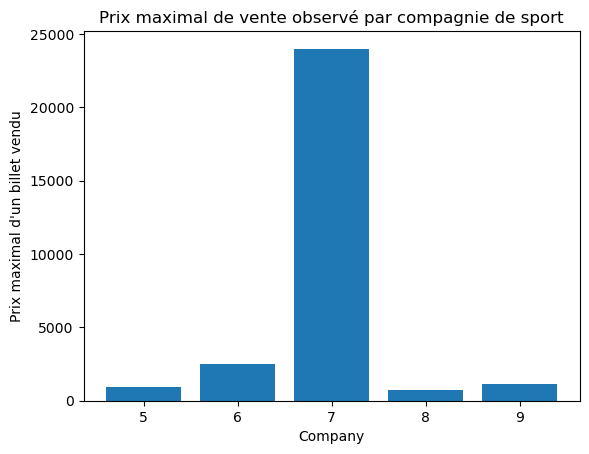

In [14]:
maximum_price_paid(customer_sport)

In [ ]:
#def sale_canal(customer_sport)
 #   avg_supp_event = customer_sport['nb_suppliers'].mean()
  #  avg_supp_event.plot(kind='bar')
   # plt.xlabel("Type d'évènement")
    #plt.ylabel('Nombre de Canaux de Ventes Moyen')
    #plt.title("Nombre de Canaux de Ventes Moyen utilisé par les Consommateurs par type d'évènement")
    #plt.show()

In [ ]:
# Nombre Total de tickets achetés sur Internet par compagnie

In [15]:
for company in sport_comp:
    print(f'Statistiques Descriptives company {company}')
    company_data = customer_sport[customer_sport['number_company'] == company][['average_price', 'average_price_basket',
          'average_ticket_basket', 'purchase_count', 'total_price']]
    print(company_data.describe())

Statistiques Descriptives company 5
       average_price  average_price_basket  average_ticket_basket  \
count  145390.000000          68869.000000           68869.000000   
mean       11.070309             65.969693               3.655202   
std        16.353610            195.462869              13.119612   
min         0.000000              0.000000               1.000000   
25%         0.000000             20.000000               1.000000   
50%         0.000000             45.000000               2.000000   
75%        20.000000             79.500000               3.000000   
max       500.000000          24159.405000            2139.833333   

       purchase_count   total_price  
count    471598.00000  3.950770e+05  
mean          0.29900  2.608544e+01  
std           7.22753  2.089636e+03  
min           0.00000  0.000000e+00  
25%           0.00000  0.000000e+00  
50%           0.00000  0.000000e+00  
75%           0.00000  0.000000e+00  
max        3532.00000  1.262516e+06  


In [16]:
customer_sport["already_purchased"] = customer_sport["purchase_count"] > 0

In [17]:
def mailing_consent(customer_sport):
    df_graph = customer_sport.groupby(["number_company", "already_purchased"])["opt_in"].mean().reset_index()
    # Création du barplot groupé
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = df_graph["number_company"].unique()
    bar_width = 0.35
    bar_positions = np.arange(len(categories))
    
    # Grouper les données par label et créer les barres groupées
    for label in df_graph["already_purchased"].unique():
        label_data = df_graph[df_graph['already_purchased'] == label]
        values = [label_data[label_data['number_company'] == category]['opt_in'].values[0]*100 for category in categories]
    
        label_printed = "purchased" if label else "no purchase"
        ax.bar(bar_positions, values, bar_width, label=label_printed)
    
        # Mise à jour des positions des barres pour le prochain groupe
        bar_positions = [pos + bar_width for pos in bar_positions]
    
    # Ajout des étiquettes, de la légende, etc.
    ax.set_xlabel('Numero de compagnie')
    ax.set_ylabel('Part de consentement (%)')
    ax.set_title('Part de consentement au mailing selon les compagnies')
    ax.set_xticks([pos + bar_width / 2 for pos in np.arange(len(categories))])
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Affichage du plot
    plt.show()

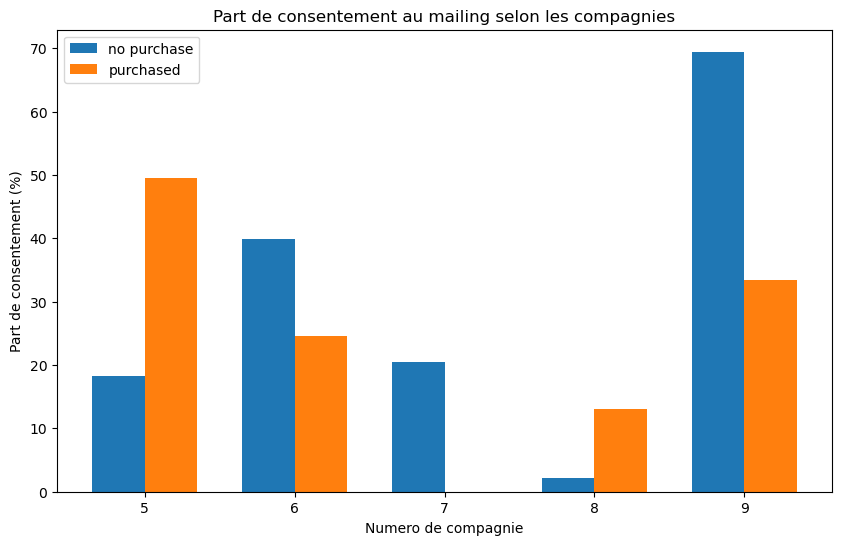

In [18]:
mailing_consent(customer_sport)

In [19]:
def gender_bar(customer_sport):
    company_genders = customer_sport.groupby("number_company")[["gender_male", "gender_female", "gender_other"]].mean().reset_index()
    
    # Création du barplot
    plt.bar(company_genders["number_company"], company_genders["gender_male"], label = "Homme")
    plt.bar(company_genders["number_company"], company_genders["gender_female"], 
            bottom = company_genders["gender_male"], label = "Femme")
    plt.bar(company_genders["number_company"], company_genders["gender_other"], 
            bottom = company_genders["gender_male"] + company_genders["gender_female"], label = "Inconnu")
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Part de clients de chaque sexe")
    plt.title("Sexe des clients de chaque compagnie de musee")
    plt.legend()

    # Définir les étiquettes de l'axe x
    plt.xticks(company_genders["number_company"], ["{}".format(i) for i in company_genders["number_company"]])
 
    
    # Affichage du barplot
    plt.show()

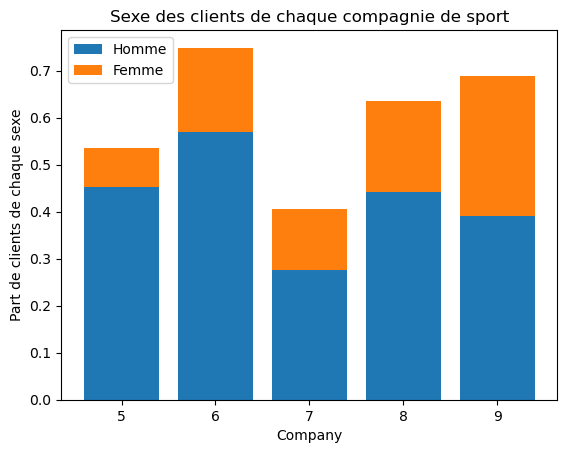

In [20]:
gender_bar(customer_sport)

In [21]:
def country_bar(customer_sport):
    company_country_fr = customer_sport.groupby("number_company")["country_fr"].mean().reset_index()
    # Création du barplot
    plt.bar(company_country_fr["number_company"], company_country_fr["country_fr"])
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Part de clients français")
    plt.title("Nationalité des clients de chaque compagnie de sport")
    
    # Affichage du barplot
    plt.show()

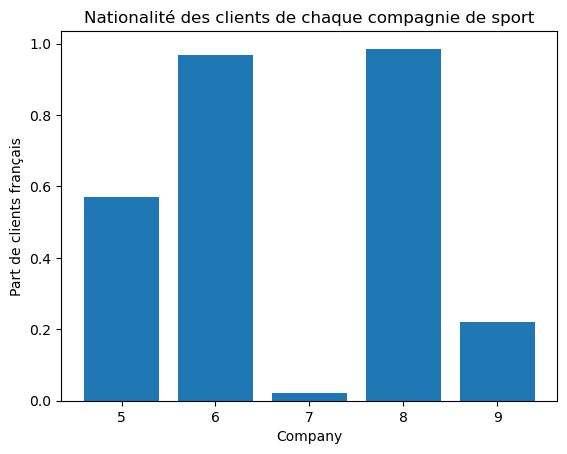

In [22]:
country_bar(customer_sport)

In [33]:
customer_sport.columns

Index(['customer_id', 'street_id', 'structure_id', 'mcp_contact_id',
       'fidelity', 'tenant_id', 'is_partner', 'deleted_at', 'gender',
       'is_email_true', 'opt_in', 'last_buying_date', 'max_price',
       'ticket_sum', 'average_price', 'average_purchase_delay',
       'average_price_basket', 'average_ticket_basket', 'total_price',
       'purchase_count', 'first_buying_date', 'country', 'gender_label',
       'gender_female', 'gender_male', 'gender_other', 'country_fr',
       'number_company', 'already_purchased'],
      dtype='object')

### 2. campaigns_information

In [23]:
print("Nombre de lignes de la table : ",campaigns_sport.shape[0])
campaigns_sport.isna().sum()

Nombre de lignes de la table :  463098


customer_id                 0
nb_campaigns                0
nb_campaigns_opened         0
time_to_open           178826
number_company              0
dtype: int64

In [24]:
def lazy_customer_plot(campaigns_sport_kpi):
    company_lazy_customers = campaigns_sport_kpi.groupby("number_company")["no_campaign_opened"].mean().reset_index()
    # Création du barplot
    plt.bar(company_lazy_customers["number_company"], company_lazy_customers["no_campaign_opened"])
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Part de clients n'ayant ouvert aucun mail")
    plt.title("Part de clients n'ayant ouvert aucun mail pour les compagnies de sport")
    
    # Affichage du barplot
    plt.show()

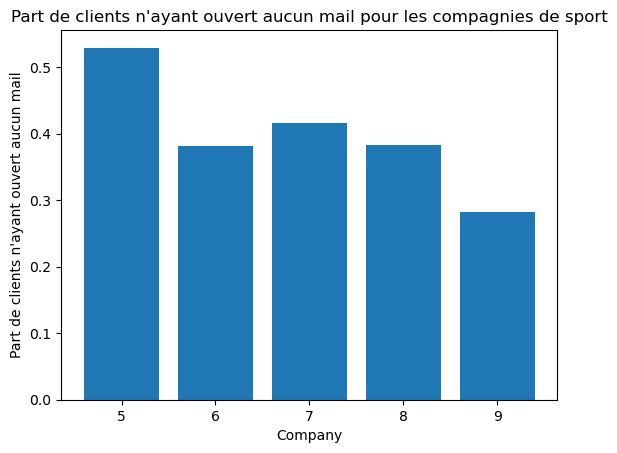

In [25]:
lazy_customer_plot(campaigns_sport_kpi)

In [31]:
def campaigns_effectiveness(customer_sport, Train=False):
    if not Train:
        customer_sport["already_purchased"] = customer_sport["purchase_count"]>0

    nb_customers_purchasing = customer_sport[customer_sport["already_purchased"]].groupby(["number_company","already_purchased"])["customer_id"].count().reset_index()
    nb_customers_no_purchase = customer_sport[~customer_sport["already_purchased"]].groupby(["number_company","already_purchased"])["customer_id"].count().reset_index()

    plt.bar(nb_customers_purchasing["number_company"], nb_customers_purchasing["customer_id"]/1000, label = "has purchased")
    plt.bar(nb_customers_no_purchase["number_company"], nb_customers_no_purchase["customer_id"]/1000, 
            bottom = nb_customers_purchasing["customer_id"]/1000, label = "has not purchased")
    
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Nombre de clients (en milliers)")
    plt.title("Nombre de clients ayant acheté ou été ciblés par des mails pour les compagnies de sport")
    plt.legend()
    
    # Affichage du barplot
    plt.show()

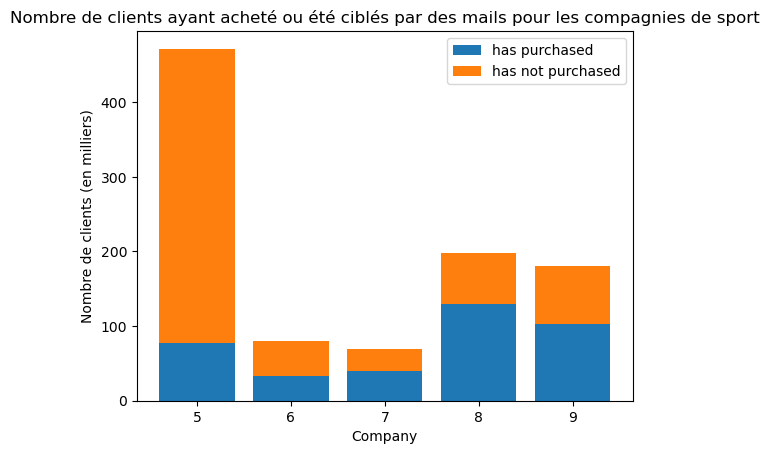

In [32]:
campaigns_effectiveness(customer_sport)

## Evolution des Commandes

In [35]:
products_sport.columns

Index(['ticket_id', 'customer_id', 'purchase_id', 'event_type_id',
       'supplier_name', 'purchase_date', 'amount', 'is_full_price',
       'name_event_types', 'name_facilities', 'name_categories', 'name_events',
       'name_seasons', 'start_date_time', 'end_date_time', 'open'],
      dtype='object')

In [41]:
campaigns_sport

customer_id  nb_campaigns  nb_campaigns_opened  \
0         5_160516            26                  2.0   
1         5_160517            73                 49.0   
2         5_160518            25                  0.0   
3         5_160519            46                  5.0   
4         5_160520            35                  9.0   
...            ...           ...                  ...   
463093   9_1720340             1                  0.0   
463094   9_1720352             1                  1.0   
463095   9_1720353             1                  0.0   
463096   9_1720354             1                  1.0   
463097   9_1720355             1                  1.0   

                    time_to_open  number_company  no_campaign_opened  
0                0 days 01:30:27               5               False  
1      2 days 01:30:16.909090909               5               False  
2                            NaT               5                True  
3         0 days 09:31:47.250000               5               False  
4      1 days 14:34:51.571428571               5               False  
...                          ...             ...                 ...  
463093                       NaT               9                True  
463094           0 days 08:30:32               9               False  
463095                       NaT               9                True  
463096           0 days 00:00:05               9               False  
463097           0 days 00:19:39               9               False  

[463098 rows x 6 columns]

In [53]:
def sale_dynamics(products_sport, campaigns_sport_brut):
    # Mois du premier achat
    purchase_min = products_sport.groupby(['customer_id'])['purchase_date'].min().reset_index()
    purchase_min.rename(columns = {'purchase_date' : 'first_purchase_event'}, inplace = True)
    purchase_min['first_purchase_event'] = pd.to_datetime(purchase_min['first_purchase_event'])
    purchase_min['first_purchase_month'] = pd.to_datetime(purchase_min['first_purchase_event'].dt.strftime('%Y-%m'))

    # Mois du premier mails
    first_mail_received = campaigns_sport_brut.groupby('customer_id')['sent_at'].min().reset_index()
    first_mail_received.rename(columns = {'sent_at' : 'first_email_reception'}, inplace = True)
    first_mail_received['first_email_reception'] = pd.to_datetime(first_mail_received['first_email_reception'])
    first_mail_received['first_email_month'] = pd.to_datetime(first_mail_received['first_email_reception'].dt.strftime('%Y-%m'))

    # Fusion 
    known_customer = pd.merge(purchase_min[['customer_id', 'first_purchase_month']], 
                          first_mail_received[['customer_id', 'first_email_month']], on = 'customer_id', how = 'outer')

    # Mois à partir duquel le client est considere comme connu

    known_customer['known_date'] = pd.to_datetime(known_customer[['first_email_month', 'first_purchase_month']].min(axis = 1), utc = True, format = 'ISO8601')

    # Nombre de commande par mois
    purchases_count = pd.merge(products_sport[['customer_id', 'purchase_id', 'purchase_date']].drop_duplicates(), known_customer[['customer_id', 'known_date']], on = ['customer_id'], how = 'inner')
    purchases_count['is_customer_known'] = purchases_count['purchase_date'] > purchases_count['known_date'] + pd.DateOffset(months=1)
    purchases_count['purchase_date_month'] = pd.to_datetime(purchases_count['purchase_date'].dt.strftime('%Y-%m'))
    purchases_count = purchases_count[purchases_count['customer_id'] != 1]
    
    # Nombre de commande par mois par type de client
    nb_purchases_graph = purchases_count.groupby(['purchase_date_month', 'is_customer_known'])['purchase_id'].count().reset_index()
    nb_purchases_graph.rename(columns = {'purchase_id' : 'nb_purchases'}, inplace = True)
    
    nb_purchases_graph_2 = purchases_count.groupby(['purchase_date_month', 'is_customer_known'])['customer_id'].nunique().reset_index()
    nb_purchases_graph_2.rename(columns = {'customer_id' : 'nb_new_customer'}, inplace = True)

    # Graphique en nombre de commande
    purchases_graph = nb_purchases_graph
    
    purchases_graph_used = purchases_graph[purchases_graph["purchase_date_month"] >= datetime(2021,3,1)]
    purchases_graph_used_0 = purchases_graph_used[purchases_graph_used["is_customer_known"]==False]
    purchases_graph_used_1 = purchases_graph_used[purchases_graph_used["is_customer_known"]==True]
    
    
    # Création du barplot
    plt.bar(purchases_graph_used_0["purchase_date_month"], purchases_graph_used_0["nb_purchases"], width=12, label = "Nouveau client")
    plt.bar(purchases_graph_used_0["purchase_date_month"], purchases_graph_used_1["nb_purchases"], 
            bottom = purchases_graph_used_0["nb_purchases"], width=12, label = "Ancien client")
    
    
    # commande pr afficher slt
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
    
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Mois')
    plt.ylabel("Nombre d'achats")
    plt.title("Nombre d'achats - Sport")
    plt.legend()
    
    # Affichage du barplot
    plt.show()

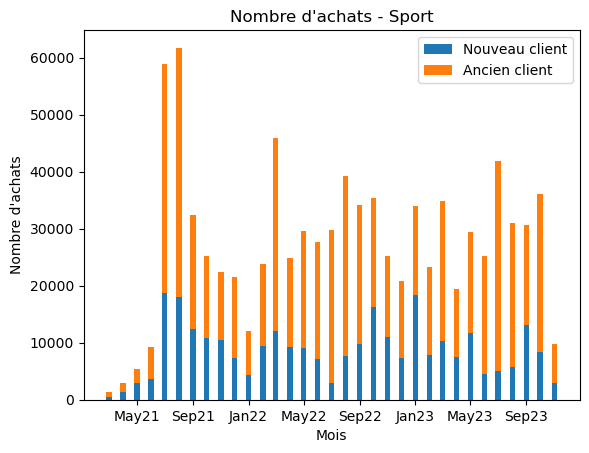

In [54]:
sale_dynamics(products_sport, campaigns_sport_brut)

# 3 - Caractéristiques Démographiques

In [98]:
directory_path = '5'
file_name = "5customersplus.csv"
file_path = "bdc2324-data" + "/" + directory_path + "/" + file_name
print(file_path)
with fs.open(file_path, mode="rb") as file_in:
    customersplus = pd.read_csv(file_in, sep=",")
    
customersplus.columns

bdc2324-data/5/5customersplus.csv


Index(['id', 'lastname', 'firstname', 'birthdate', 'email', 'street_id',
       'created_at', 'updated_at', 'civility', 'is_partner', 'extra',
       'deleted_at', 'reference', 'gender', 'is_email_true', 'extra_field',
       'identifier', 'opt_in', 'structure_id', 'note', 'profession',
       'language', 'mcp_contact_id', 'need_reload', 'last_buying_date',
       'max_price', 'ticket_sum', 'average_price', 'fidelity',
       'average_purchase_delay', 'average_price_basket',
       'average_ticket_basket', 'total_price', 'preferred_category',
       'preferred_supplier', 'preferred_formula', 'purchase_count',
       'first_buying_date', 'last_visiting_date', 'zipcode', 'country', 'age',
       'tenant_id'],
      dtype='object')

In [95]:
def load_customer_brut_dataset(directory_path):
    file_name = str(directory_path) + "customersplus.csv"
    print(file_name)
    file_path = "bdc2324-data" + "/" + str(directory_path) + "/" + file_name
    print(file_path)
    with fs.open(file_path, mode="rb") as file_in:
        customersplus = pd.read_csv(file_in, sep=",")
    return customersplus

In [99]:
def percent_of_na(company, column):
    df = load_customer_brut_dataset(company)
    if column in df.columns:
        na_percentage = df[column].isna().mean() * 100
        non_na_percentage = 100 - na_percentage
        
        labels = ['Valeurs Manquantes', 'Non-Valeurs Manquantes']
        sizes = [na_percentage, non_na_percentage]
        colors = ['#ff9999','#66b3ff']
        explode = (0.1, 0)
    
        plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.axis('equal') 
        plt.title('Pourcentage de Valeurs Manquantes : {}'.format(column))
        #plt.show()
    else:
        print(f"The column {column} doesn't exist for the company {company}")

5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customersplus.csv
5customersplus.csv
bdc2324-data/5/5customerspl

KeyboardInterrupt: 

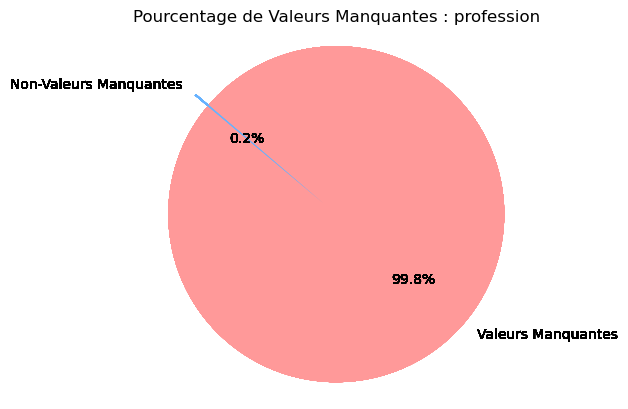

In [100]:
for company in customer_sport['number_company']:
    percent_of_na(company, 'profession')